#### imports

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from scripts.emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)
from scripts.helper_functions import F_test
from scipy import stats


#### Visualization

In [3]:
TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

### Sapling Competition 

# Perform targeted attack

In [4]:
from scripts.experiments import target_attack, run_mutated_graph_experiment, failure, run_n_graph_failure_experiments
from tqdm import tqdm

from scripts.forest_generator import generate_barabasi_forest, generate_random_graph

N = 10
# initialize forest data
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)

degrees_dict = {n: d for n, d in G.degree()}
sorted_trees = sorted(degrees_dict.keys(), key=degrees_dict.get)

In [35]:
# failure_result = run_mutated_graph_experiment(G, failure, sorted_trees, n_mutations=50)
failure_results = run_n_graph_failure_experiments(G, sorted_trees, N)
attack_result = run_mutated_graph_experiment(G, target_attack, sorted_trees, n_mutations=51)

forest_outputfile = "data/attack_failure_data_forest.npz"
np.savez(forest_outputfile, attack_result, failure_results)

running 10 iterations of failure...


failure:  94%|█████████▍| 48/51 [00:27<00:00, 23.28it/s]/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
failure:  24%|██▎       | 12/51 [00:14<00:45,  1.17s/it]


KeyboardInterrupt: 

In [36]:
# initialize Barabasi-albert scale free
G = generate_barabasi_forest(G.number_of_nodes(), m=9, seed=503)

degrees_dict = {n: d for n, d in G.degree()}
sorted_trees = sorted(degrees_dict.keys(), key=degrees_dict.get)

attack_result = run_mutated_graph_experiment(G, target_attack, sorted_trees, n_mutations=51)
failure_results = run_n_graph_failure_experiments(G, sorted_trees, N)

outputfile = "data/attack_failure_data_scalefree.npz"
np.savez(outputfile, attack_result, failure_results)

target_attack: 100%|██████████| 51/51 [00:21<00:00,  2.35it/s]


running 10 iterations of failure...


failure: 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]


In [43]:
# initialize Barabasi-albert scale free
G = generate_random_graph(G.number_of_nodes() ,p=0.2, seed=512)

degrees_dict = {n: d for n, d in G.degree()}
sorted_trees = sorted(degrees_dict.keys(), key=degrees_dict.get)

attack_result = run_mutated_graph_experiment(G, target_attack, sorted_trees, n_mutations=48)
failure_results = run_n_graph_failure_experiments(G, sorted_trees, N)

random_outputfile = "data/attack_failure_data_random.npz"
np.savez(random_outputfile, attack_result, failure_results)

target_attack: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


running 10 iterations of failure...


failure:  98%|█████████▊| 50/51 [34:22<00:41, 41.24s/it]   


ValueError: zero-size array to reduction operation maximum which has no identity

In [5]:
def load_attack_data(outputfile):
    data = np.load(outputfile, allow_pickle=True)
    attack_result = data["arr_0"][()]
    failure_results = data["arr_1"][()]
    return attack_result, failure_results

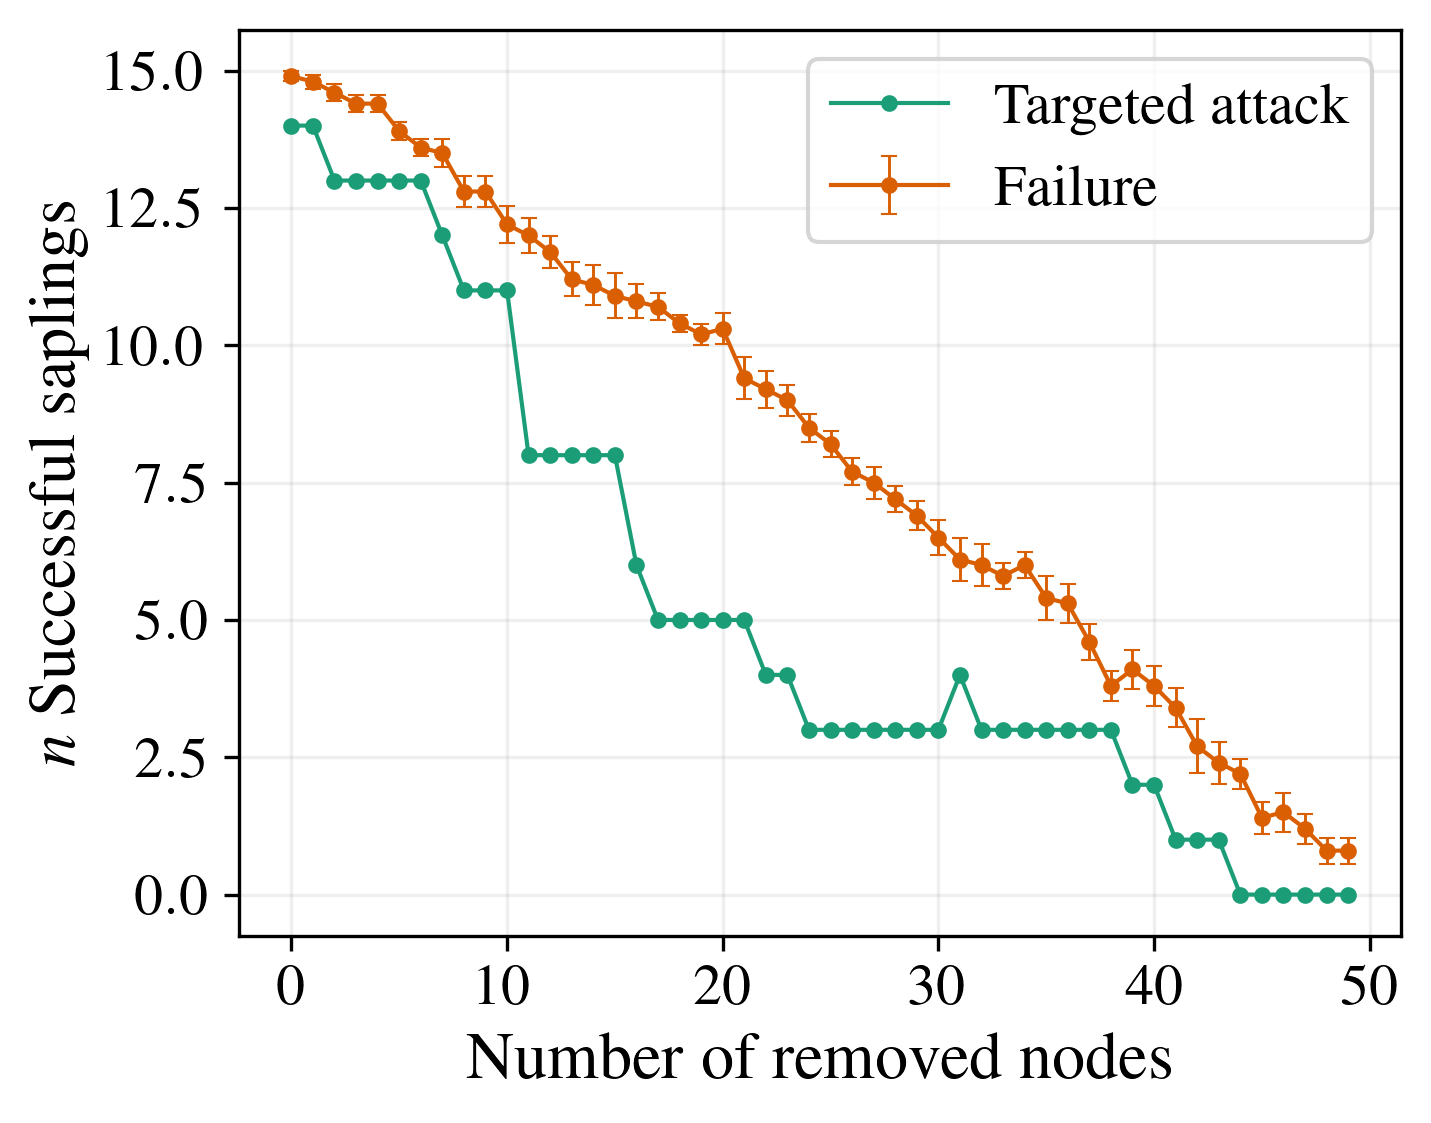

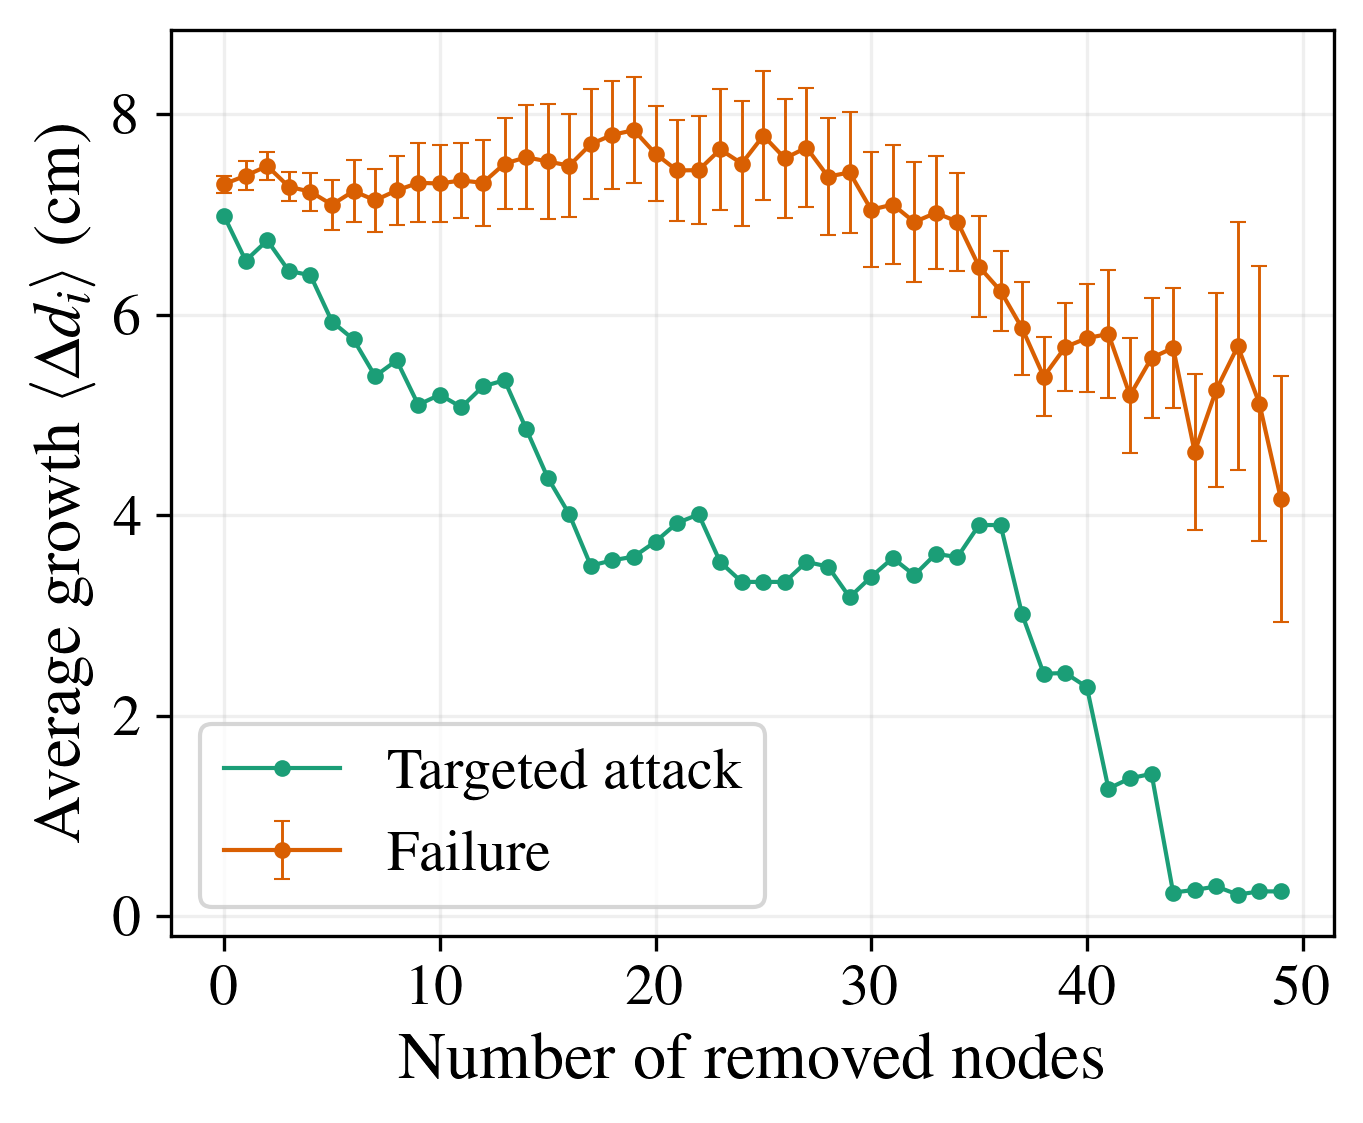

In [20]:
N = 10
outputfile = "data/attack_failure_data_forest.npz"
# outputfile = "attack_failure_data_scalefree.npz"
# outputfile = "attack_failure_data_random.npz"

attack_result, failure_results = load_attack_data(outputfile)

plt.figure(figsize=(5, 4), dpi=300)

plt.plot([d["nsuccesses"] for d in attack_result["analysis"]], label="Targeted attack", marker="o", ms=3)
plt.errorbar(np.arange(50), np.mean(failure_results["nsuccesses"], axis=0), np.std(failure_results["nsuccesses"],axis=0) / np.sqrt(N), label="Failure",
             marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2,)
plt.xlabel("Number of removed nodes")
plt.ylabel("$n$ Successful saplings")
plt.legend()
if TEX_PLOTS:
    plt.savefig("figures/attack_n_succesful_saplings.png", bbox_inches="tight")
plt.show()

plt.figure(figsize=(5, 4), dpi=300)

plt.plot([d["average_growth"] for d in attack_result["analysis"]], label="Targeted attack", marker="o", ms=3)
plt.errorbar(np.arange(50), np.mean(failure_results["average_growth"], axis=0),np.std(failure_results["average_growth"], axis=0)/np.sqrt(N) , label="Failure",
             marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2,)
plt.xlabel("Number of removed nodes")
plt.ylabel(r"Average growth $\langle \Delta d_i \rangle$ (cm)")
plt.legend() 
if TEX_PLOTS:
    plt.savefig("figures/attack_average_growth.png", bbox_inches="tight")
plt.show() 